<a href="https://colab.research.google.com/github/turtlemb/hugging_face/blob/main/hugging_face_text_classification_AI_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging Face Text Classification

* Resource notebook: https://www.learnhuggingface.com/notebooks/hugging_face_text_classification_tutorial
* Setup steps: https://www.learnhuggingface.com/extras/setup

Note: A GPU is needed on Google Colab, go to Runtime -> Change runtime type -> Hardware accelerator -> GPU. T4 GPU is the only one available for free (entry-level GPU).

### 2. Import necessary libraries.

In [ ]:
# Install dependencies (this is mostly for Google Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio
  import datasets, evaluate, accelerate
  import gradio as gr

import random

import numpy as np
import pandas as pd

import torch
import transformers

print(f'Using transformers version: {transformers.__version__}')
print(f'Using torch version: {torch.__version__}')
print(f'Uding datasets version: {datasets.__version__}')

Using transformers version: 4.48.3
Using torch version: 2.5.1+cu124
Uding datasets version: 3.3.2


3. Getting a dataset

Building food not food text classification model: need food not food text dataset.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("mrdbourke/learn_hf_food_not_food_image_captions")
dataset

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

In [ ]:
# What features are there in our dataset?
dataset.column_names

{'train': ['text', 'label']}

In [ ]:
# Access the training split
dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

In [ ]:
dataset["train"][0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

# Inspect random samples

In [ ]:
random_indexs = random.sample(range(len(dataset["train"])), 5)
print(random_indexs)

random_samples = dataset["train"][random_indexs]
# random_samples
print(f'[INFO] Random samples from dataset:\n')
for text, label in zip(random_samples['text'], random_samples["label"]):
  print(f'Text: {text} | Label: {label}')


[69, 186, 227, 189, 61]
[INFO] Random samples from dataset:

Text: A slice of veggie pizza loaded with colorful and nutritious vegetables | Label: food
Text: Traditional Japanese flavored sushi roll with pickled plum or fermented soybeans. | Label: food
Text: A plate of sliced pineapple with a side of whipped cream and a cherry on top | Label: food
Text: Set of board games stacked on a shelf | Label: not_food
Text: Basketball hoop set up in a driveway | Label: not_food


In [ ]:
# Get unique label values
dataset['train'].unique('label')

['food', 'not_food']

In [ ]:
# Check the count of each label
from collections import Counter

Counter(dataset['train']['label'])

Counter({'food': 125, 'not_food': 125})

In [ ]:
# Turn our dataset into a DataFrame and get a random sample
food_not_food_df = pd.DataFrame(dataset['train'])
food_not_food_df.sample(7)

,text,label
210,"A bowl of mixed berries, including blueberries...",food
50,Red brick fireplace with a mantel serving as a...,not_food
66,"Cuddling with a cat on her lap, a woman enjoys...",not_food
64,"Yellow squash in a bowl, sprinkled with oregan...",food
86,"A fruit kabob with a variety of fruits, such a...",food
145,"Fragrant Thai green curry, featuring vegetable...",food
235,Pizza with a unique topping combination of pin...,food


In [ ]:
# Getting value counts of labels via DataFrame
food_not_food_df['label'].value_counts()

,count
label,
food,125
not_food,125


# 4. Preparing data for text classification

We want to:

1. Tokenize out text - turn our text into numbers (this goes for labels as well).

2. Create a train/text split - want to train our model on the training split and evaluate our model on the test split.

In [ ]:
# Create a mapping for labels to numeric value
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

print(id2label)
print(label2id)

{0: 'not_food', 1: 'food'}
{'not_food': 0, 'food': 1}


In [ ]:
# Create mappings programmatically from dataset
id2label = {idx: label for idx, label in enumerate(dataset['train'].unique("label")[::-1])}
# To programmatically generate the inverse:
label2id = {label: idx for idx, label in id2label.items()}
print(id2label)
print(label2id)

{0: 'not_food', 1: 'food'}
{'not_food': 0, 'food': 1}


In [ ]:
# This is how the previous comprehensions work under the hood:
id2label = {}
for idx, label in enumerate(dataset["train"].unique('label')[::-1]):
  print(idx, label)
  id2label[idx] = label


0 not_food
1 food


In [ ]:
# Turn labels into 0 or 1
def map_labels_to_numbers(example):
  example['label'] = label2id[example['label']]
  return example

example_sample = {"text": "This is a sentence about my favourite food: honey", "label": "food"}

# Test our function
map_labels_to_numbers(example_sample)


{'text': 'This is a sentence about my favourite food: honey', 'label': 1}

In [ ]:
# Map our dataset labels to numbers (the whole thing)
# We do this with dataset.map() - https://huggingface.co/docs/datasets/en/process#map
dataset = dataset['train'].map(map_labels_to_numbers)
dataset[:5]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

In [ ]:
# Shuffle data and look at 5 more random samples
dataset.shuffle()[:5]

{'text': ['Washing machine and dryer side by side in a laundry room',
  'Assorted sushi rolls on a plate, featuring California rolls and spicy tuna rolls.',
  'Vibrant red curry with tofu and bell peppers, featuring tofu and sweet bell peppers in a rich coconut milk sauce.',
  'Spicy vindaloo curry with tender pork pieces, featuring a fiery sauce made with vinegar and chili peppers, perfect for bold flavor lovers.',
  "Pizza with a meat lover's theme, including sausage, bacon, and pepperoni"],
 'label': [0, 1, 1, 1, 1]}

### Split the dataset into training and test sets
* Train set = model will learn patterns on this dataset
* Validation set (optional) = we can tune our model's hyper-parameters on this set
* Test set = model will evaluate patterns on this dataset

We can split our dataset using 'datasets.Dataset.train_test_split'. https://huggingface.co/docs/datasets/v3.3.0/process#split


In [ ]:
# Split our dataset into train/test splits
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

In [ ]:
random_idx_train = random.randint(0, len(dataset["train"]))
random_sample_train = dataset['train'][random_idx_train]
random_sample_train

{'text': 'A white car parked in a driveway with a wooden fence behind it',
 'label': 0}

In [ ]:
random_idx_test = random.randint(0, len(dataset['test']))
random_sample_test = dataset['test'][random_idx_test]
random_sample_test

{'text': 'Wooden dresser with a mirror reflecting the room', 'label': 0}

### Tokenizing our text data (turning text into numbers)

The premise of tokenization is to turn words into numbers.

E.g. "I love pizza!" -> [30, 145, 678, 999]

-

The 🤗 transformers library has built-in support for 🤗 tokenizers.

And the class transformers.AutoTokenizer helps pair a model to a tokenizer.

--

* To find all models: https://huggingface.co/models
* Model/tokenizer we're going to use: https://huggingface.co/distilbert/distilbert-base-uncased
* Models are often paired with tokenizers
* Tokenizer = turn text into numbers
* Model = finds patterns in those numbers

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased", use_fast=True) # use fast implementation (on by default, note: this requires RUST installed)
tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
# Test out tokenizer
# Open AI = [40, 3021, 23317, 0]
tokenizer('I love pizza!')

{'input_ids': [101, 1045, 2293, 10733, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

* 'input_ids' = our text turned into numbers
* 'attention_mask' = whether or not to pay attention to certain tokens (1 = yes pay attention, 0 = no don't pay attention)

In [ ]:
# Get the length of our tokenizer vocab
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f'[INFO] Number of items in our tokenizer vocab: {length_of_tokenizer_vocab}')

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f'[INFO] Max tokenizer input sequence length: {max_tokenizer_input_sequence_length}')

[INFO] Number of items in our tokenizer vocab: 30522
[INFO] Max tokenizer input sequence length: 512


In [ ]:
# Does 'Martin' occur in the vocab?
tokenizer.vocab['martin']

3235

In [ ]:
tokenizer('akash')

{'input_ids': [101, 9875, 4095, 102], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer('akash').input_ids)

['[CLS]', 'aka', '##sh', '[SEP]']

In [ ]:
# Try to tokenize an emoji
tokenizer.convert_ids_to_tokens(tokenizer('🤗').input_ids)

['[CLS]', '[UNK]', '[SEP]']

In [ ]:
# Get the first 5 items in the tokenizer vocab
sorted(tokenizer.vocab.items())[:5]

[('!', 999), ('"', 1000), ('#', 1001), ('##!', 29612), ('##"', 29613)]

In [ ]:
import random
random.sample(sorted(tokenizer.vocab.items()), k=5)

[('keep', 2562),
 ('271', 25103),
 ('##ovich', 12303),
 ('sava', 28350),
 ('parchment', 22433)]

### Making a preprocessing function to tokenize text

Want to make it easy to go from sample -> tokenized_sample.

In [ ]:
def tokenize_text(examples):
  """
  Tokenize given example text and return the tokenized text.
  """
  return tokenizer(examples['text'],
                   padding=True, # pad short sequences to the longest sequence length in batch (e.g. if sample length = 100, sample will be padded to 512 or the longest sample in batch)
                   truncation=True) # truncate long sequences to max length model can handle (e.g. if sample length = 1000, ,model length = 512, sample will be shortened to 512)

* Extra resource: padding and truncation in the docs: https://huggingface.co/docs/transformers/en/pad_truncation

In [ ]:
example_sample_2 = {'text': 'I love pizza!', 'label': 1}

# Test the function
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
long_text = 'I love pizza ' * 1000
len(long_text)

13000

In [ ]:
tokenized_long_text = tokenize_text({'text': long_text, 'label': 1})
len(tokenized_long_text['input_ids'])

512

In [ ]:
# Map our tokenize_text function to the dataset
tokenized_dataset = dataset.map(function=tokenize_text,
                                batched=True, # set batched=True to tokenize across batches of samples at a time rather than one at a time
                                batch_size=1000)
tokenized_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

* **Note:** In machine learning, it is often faster to do things in batches rather than one at a time due to leveraging computer hardware parallelization. See more in the map documentation: https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map

In [ ]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [ ]:
tokenizer.all_special_ids

[100, 102, 0, 101, 103]

In [ ]:
# Get two samples from the tokenized datasets
train_tokenized_sample = tokenized_dataset['train'][0]
test_tokenized_sample = tokenized_dataset['test'][0]

for key in train_tokenized_sample.keys():
  print(f'[INFO] Key: {key}')
  print(f'Train sample: {train_tokenized_sample[key]}')
  print(f'Test sample: {test_tokenized_sample[key]}\n')

[INFO] Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



### Tokenization takeaways

1. Tokenizers = turn data into numbers (e.g. text -> map to number)
2. Many models out there that have many different tokenizers, Hugging Face's 'Auto' (e.g. 'AutoTokenizer', 'AutoProcessor', 'AutoModel', etc ... help to match tokenizers to models)
3. Tokenization can happen in paralell using map and batched functions

## Setting up an evaluation metric

What we want to do: use the evaluation metric to get a numerical idea of how our model is performing.

Some common evaluation metrics for classification:

- Accuracy (how many examples, out of 100, did you get correct?)
- Precision
- Recall
- F1 score

Evaluation metric is important because some projects may have an evaluation threshold you need to fulfill.

E.g. When I worked on insurance claim classification = required >=98% test accuracy to be commercially viable.

Some places for evaluation metrics:
* Scikit-learn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
* Hugging Face evaluate: https://huggingface.co/docs/evaluate/en/index

In [ ]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels
  return accuracy_metric.compute(predictions=predictions, references=labels)


In [ ]:
# Example predictions and accuracy score
example_preds_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_preds_one_incorrect = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Test the function
print(f'Accuracy when all predictions are correct: {compute_accuracy((example_preds_all_correct, example_labels))}')
print(f'Accuracy when one prediction is incorrect: {compute_accuracy((example_preds_one_incorrect, example_labels))}')

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is incorrect: {'accuracy': 0.9}


## Setting up a model for training

* We're going to be using transfer learning.
* Transfer learning is a powerful technique, unique to deep learning models that enables us to use the patterns one model has learnt on another problem for our own problem.
* See more on transfer learning here: https://en.wikipedia.org/wiki/Transfer_learning

Workflow for training:

1. Create and preprocess data ✅
2. Define the model we'd like to use for our problem: https://huggingface.co/models or see the "task guides" in HF Transformers docs: https://huggingface.co/docs/transformers/main/en/tasks/sequence_classification
3. Define our training arguments for training our model 'transformers.TrainingArguments'
4. Pass 'TrainingArguments' to an instance of 'transformers.Trainer'
5. Train the model by calling 'Trainer.train()'
6. Save the model (to our local machine or to the Hugging Face Hub)
7. Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data of course!)
8. Turn the model into a shareable demo

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
                  pretrained_model_name_or_path = 'distilbert/distilbert-base-uncased',
                  num_labels = 2, #classify into food not_food
                  id2label = id2label,
                  label2id = label2id
                  )

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Our model is comprised of the follwing parts:

1. 'embeddings' - embeddings are a form of learned representation of tokens. So if tokens are a direct mapping from the token to number, embeddings are a learned vector representation.
2. 'transformer' - our model architecture backbone, this has discovered patterns/relationships in the embeddings.
3. 'classifier' - we need to customize this layer to suit our problem.

In [ ]:
model([123, 456, 789]) # try to pass numbers to our model; results in error

Note: If you get input errors from passing a sample to a model, make sure the sample you pass to your model is formatted in the same way your model was trained on. For example, if your model used a specific tokenizer, make sure to tokenize your text before passing it to the model.

If there are still errors, the model wasn't trained yet and cannot properly interpret the data being given to it.

In [ ]:
model(tokenized_dataset['train'][0]) # try to pass data again; results in error

In [ ]:
**tokenized_dataset['train'][0] # try to see the effect of **

In [ ]:
model(**tokenized_dataset['train'][0]) # ** syntax means we want to pass on all the keys in the dictionary to our model

In [ ]:
model(input_ids = tokenized_dataset['train'][0]['input_ids'],
      attention_mask = tokenized_dataset['train'][0]['attention_mask']) # we can't pass anything to our model because it isn't yet trained

### Count the parameters in our model

Weight/parameters = small numeric opportunities for a model to learn patterns in data.

In [ ]:
# list(model.parameters())

In [ ]:
def count_params(model):
  '''
  Count the parameters of a PyTorch model.
  '''
  trainable_parameters = sum(param.numel() for param in model.parameters() if param.requires_grad)
  total_parameters = sum(param.numel() for param in model.parameters())

  return {'trainable_parameters': trainable_parameters, 'total_parameters': total_parameters}

count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

Looks like our model has around 67M parameters and **all** of them are trainable.

Note:
* Generally, the more parameters a model has, the more capacity it has to learn.
* Comparison models such as Llama 3 8B have 8 billion parameters.
* If you want the best possible performance, generally more parameters is better.
  * However, more parameters = more compute + time.
  * You'll be surprised how well a smaller model can perform with specific data.

In [ ]:
8_000_000_000 / 67_000_000 # we can write large numbers in this format in Colab to more easily read them

119.40298507462687

### Create a directory for saving models

In [ ]:
# Create model output directory
from pathlib import Path

# Create models dir
models_dir = Path('models')
models_dir.mkdir(exist_ok = True)

# Create model save name
model_save_name = 'learn_hf_food_not_food_text_classifier-distilbert-base-uncased'

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased')

### Setting up training arguments (hyperparameters) with TrainingArguments

1. ✅Create and preprocess data
2. ✅Define the model we'd like to use for our problem: https://huggingface.co/models or see the "task guides" in HF Transformers docs: https://huggingface.co/docs/transformers/main/en/tasks/sequence_classification
3. Define our training arguments for training our model 'transformers.TrainingArguments'
  * These are also known as "hyperparameters" = settings on your model that you can adjust
  * Parameters = weights/patterns in the model that get updated automatically
4. Pass 'TrainingArguments' to an instance of 'transformers.Trainer'
5. Train the model by calling 'Trainer.train()'
6. Save the model (to our local machine or to the Hugging Face Hub)
7. Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data of course!)
8. Turn the model into a shareable demo

In [ ]:
from transformers import TrainingArguments

print(f'[INFO] Saving model checkpoints: {model_save_dir}')

BATCH_SIZE = 32

# Create training arguments
training_args = TrainingArguments(
    output_dir = model_save_dir,
    learning_rate = 0.0001,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    num_train_epochs = 10,
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    save_total_limit = 3,
    use_cpu = False,
    seed = 42,
    load_best_model_at_end = True,
    logging_strategy = 'epoch',
    report_to = 'none',
    # hub_token = 'YOUR_TOKEN_HERE_hf-shdsjhefkhhfjkhfjkh4347463478jnbn',
    # push_to_hub = True # if you want your model to save directly to the Hugging Face Hub after training,
    hub_private_repo = False # when uploading to Hugging Face Hub, do you want your repo to be private or public? (default: public)
)

[INFO] Saving model checkpoints: models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


In [ ]:
training_args

### Setting up an instance of Trainer

1. ✅Create and preprocess data
2. ✅Define the model we'd like to use for our problem: https://huggingface.co/models or see the "task guides" in HF Transformers docs: https://huggingface.co/docs/transformers/main/en/tasks/sequence_classification
3. ✅Define our training arguments for training our model 'transformers.TrainingArguments'
  * These are also known as "hyperparameters" = settings on your model that you can adjust
  * Parameters = weights/patterns in the model that get updated automatically
4. Pass 'TrainingArguments' to an instance of 'transformers.Trainer'
5. Train the model by calling 'Trainer.train()'
6. Save the model (to our local machine or to the Hugging Face Hub)
7. Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data of course!)
8. Turn the model into a shareable demo

* Docs for 'transformers.Trainer': https://huggingface.co/docs/transformers/v4.49.0/en/main_classes/trainer#trainer

In [ ]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis = 1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import Trainer

# Setup Trainer instance
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_dataset['train'],
    eval_dataset = tokenized_dataset['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_accuracy
)

trainer

<ipython-input-47-cc243862ddb1>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Train the model by calling Trainer.train()

1. ✅Create and preprocess data
2. ✅Define the model we'd like to use for our problem: https://huggingface.co/models or see the "task guides" in HF Transformers docs: https://huggingface.co/docs/transformers/main/en/tasks/sequence_classification
3. ✅Define our training arguments for training our model 'transformers.TrainingArguments'
  * These are also known as "hyperparameters" = settings on your model that you can adjust
  * Parameters = weights/patterns in the model that get updated automatically
4. ✅Pass 'TrainingArguments' to an instance of 'transformers.Trainer'
5. Train the model by calling 'Trainer.train()'
6. Save the model (to our local machine or to the Hugging Face Hub)
7. Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data of course!)
8. Turn the model into a shareable demo

In [ ]:
input_predictions = np.array([[-5.9671326, 6.092786]])
input_references = np.array([0])

# need to get the maximum value from the model output as this is the "most likely" label according to the model
# see np.argmax docs (returns the index of maximum value along an axis): https://numpy.org/doc/2.2/reference/generated/numpy.argmax.html
if len(input_predictions.shape) >= 2:
  input_predictions = np.argmax(input_predictions, axis = 1)

input_predictions

array([1])

In [ ]:
compute_accuracy((input_predictions, input_references))

{'accuracy': 0.0}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.450000,0.166496,0.960000
2,0.067800,0.007811,1.000000
3,0.005600,0.002160,1.000000
4,0.001900,0.001070,1.000000
5,0.001000,0.000714,1.000000
6,0.000700,0.000569,1.000000
7,0.000600,0.000499,1.000000
8,0.000500,0.000462,1.000000
9,0.000500,0.000443,1.000000
10,0.000500,0.000436,1.000000


TrainOutput(global_step=70, training_loss=0.05292068286466279, metrics={'train_runtime': 511.588, 'train_samples_per_second': 3.909, 'train_steps_per_second': 0.137, 'total_flos': 18110777160000.0, 'train_loss': 0.05292068286466279, 'epoch': 10.0})

### Save the model for later use

> **Note** If you are saving a model to Google Colab, note that it will disappear from your Colab instance when it disconnects.

In [ ]:
# Save model
print(f'[INFO] Saving model to {model_save_dir}')
trainer.save_model(output_dir = model_save_dir)

[INFO] Saving model to models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased


In [ ]:
list(model.parameters()) # to have a look at the tensors

### Inspect the model training metrics

In [ ]:
# Get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all
trainer_history_training_time = trainer_history_all[-1]

# View the first 3
trainer_history_metrics[:3]

[{'loss': 0.45,
  'grad_norm': 1.9463328123092651,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.16649629175662994,
  'eval_accuracy': 0.96,
  'eval_runtime': 2.7406,
  'eval_samples_per_second': 18.244,
  'eval_steps_per_second': 0.73,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.0678,
  'grad_norm': 0.18325099349021912,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 14}]

In [ ]:
import pprint

# Extract eval and training metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through our metrics
for item in trainer_history_metrics:
  item_keys = list(item.keys())
  if any('eval' in item for item in item_keys):
    trainer_history_eval_set.append(item)
  else:
    trainer_history_training_set.append(item)

# Show the first from each
print(f'First two items in training set:')
pprint.pprint(trainer_history_training_set[:2])

print(f'\nFirst two items in eval epochs:')
pprint.pprint(trainer_history_eval_set[:2])

First two items in training set:
[{'epoch': 1.0,
  'grad_norm': 1.9463328123092651,
  'learning_rate': 9e-05,
  'loss': 0.45,
  'step': 7},
 {'epoch': 2.0,
  'grad_norm': 0.18325099349021912,
  'learning_rate': 8e-05,
  'loss': 0.0678,
  'step': 14}]

First two items in eval epochs:
[{'epoch': 1.0,
  'eval_accuracy': 0.96,
  'eval_loss': 0.16649629175662994,
  'eval_runtime': 2.7406,
  'eval_samples_per_second': 18.244,
  'eval_steps_per_second': 0.73,
  'step': 7},
 {'epoch': 2.0,
  'eval_accuracy': 1.0,
  'eval_loss': 0.007810888346284628,
  'eval_runtime': 2.3464,
  'eval_samples_per_second': 21.31,
  'eval_steps_per_second': 0.852,
  'step': 14}]


### Taking a look at the loss curves

Loss curves = a good visualization of your model's performance over time.

Ideally, loss curves will trend downwards.

See more here: https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

In [ ]:
# Create a pandas DataFrame for the training and evaluation metrics
trainer_history_train_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_train_df.head()
trainer_history_eval_df.head()

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.166496,0.96,2.7406,18.244,0.730,1.0,7
1,0.007811,1.00,2.3464,21.310,0.852,2.0,14
2,0.002160,1.00,2.4911,20.071,0.803,3.0,21
3,0.001070,1.00,3.3647,14.860,0.594,4.0,28
4,0.000714,1.00,2.3513,21.265,0.851,5.0,35


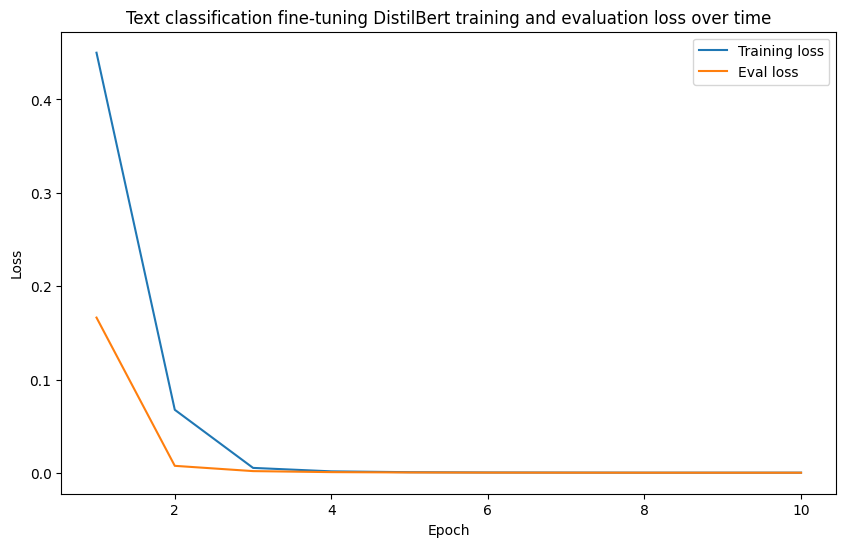

In [ ]:
# Plot the loss curves
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.plot(trainer_history_train_df['epoch'], trainer_history_train_df['loss'], label = 'Training loss')
plt.plot(trainer_history_eval_df['epoch'], trainer_history_eval_df['eval_loss'], label = 'Eval loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Text classification fine-tuning DistilBert training and evaluation loss over time')
plt.legend()
plt.show()

To learn more about overfitting and underfitting, see: https://en.wikipedia.org/wiki/Overfitting

### Pushing our model to the Hugging Face Hub

Why do this?

1. So we can share our model.

2. Other people can try it out.

3. We can keep a history of different model versions.

To write to Hugging Face:
- If on Google Colab: setup "token" with " read and write" access
- If on local machine: setup 'huggingface-cli' (https://huggingface.co/docs/huggingface_hub/guides/cli)

To save to the Huggin Face Hub, we can use the 'Trainer.push_to_hub' method: https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.push_to_hub

In [ ]:
# Save our model to Hugging Face Hub
model_upload_url = trainer.push_to_hub(
    commit_message = 'Uploading food not_food text classifier model',
    # token = 'YOUR_TOKEN_HERE' # but not recommended, instead setup the HF token in your Colab
)
print(f'[INFO] Model successfully uploaded to the Hugging Face Hub with URL: {model_upload_url}')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Model successfully uploaded to the Hugging Face Hub with URL: https://huggingface.co/turtlemb/learn_hf_food_not_food_text_classifier-distilbert-base-uncased/tree/main/


### Making and evaluating predictions on the test data

1. ✅Create and preprocess data
2. ✅Define the model we'd like to use for our problem: https://huggingface.co/models or see the "task guides" in HF Transformers docs: https://huggingface.co/docs/transformers/main/en/tasks/sequence_classification
3. ✅Define our training arguments for training our model 'transformers.TrainingArguments'
  * These are also known as "hyperparameters" = settings on your model that you can adjust
  * Parameters = weights/patterns in the model that get updated automatically
4. ✅Pass 'TrainingArguments' to an instance of 'transformers.Trainer'
5. ✅Train the model by calling 'Trainer.train()'
6. ✅Save the model (to our local machine or to the Hugging Face Hub)
7. Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data of course!)
8. Turn the model into a shareable demo

> **Note:** Evaluating a model is just as important as training a model.

We can make predictions on the test data using the Trainer.predict method:
https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.predict

In [ ]:
# Perform predictions on the test data
predictions_all = trainer.predict(tokenized_dataset['test'])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f'[INFO] Prediction metrics on the test data:')
prediction_metrics

[INFO] Prediction metrics on the test data:


{'test_loss': 0.0004361069586593658,
 'test_accuracy': 1.0,
 'test_runtime': 3.2301,
 'test_samples_per_second': 15.479,
 'test_steps_per_second': 0.619}

In [ ]:
# Model outputs raw logits
predictions_all.predictions[0]

array([-3.5225344,  4.2668843], dtype=float32)

In [ ]:
# Softmax gets all values to be between 0 & 1 and the total of the values sum to 1
# This is what's known as a "prediction probability", as the model is assigning this value to how "likely" the prediction is given the sample

torch.softmax(torch.tensor(predictions_all.predictions[0]), dim = 0)

tensor([4.1392e-04, 9.9959e-01])

> **Note**: If you want a good evaluation method, make predictions on your entire test dataset, then index on the predictions which are wrong but have high prediction probability. For example, get the top 100-1000 and go through all of the examples where the model's prediction had high probability but was incorrect -> this often leads to great insights into your data.

In [ ]:
0.99964, 0.00036015 # Note: these values don't suggest how "right" the model is, because a model can have a high prediction probability but still be wrong

(0.99964, 0.00036015)

### Let's get prediction probabilities and evaluate by hand

In [ ]:
# Predicted logits (neural network raw output called a logit) -> predictions, probabilities with torch.softmax -> predicted labels
import torch
from sklearn.metrics import accuracy_score

# 1. Get prediction probabilities with torch.softmax
pred_probs = torch.softmax(torch.tensor(prediction_values), dim = 1)
pred_probs

# 2. Get the predicted labels
pred_labels = torch.argmax(pred_probs, dim = 1)
pred_labels

# 3. Get the true labels
true_labels = tokenized_dataset["test"]['label']
true_labels

# 4. Compute prediction labels to true labels and get the test accuracy
test_accuracy = accuracy_score(y_true=true_labels,
                               y_pred=pred_labels)

print(f'[INFO] Test accuracy: {test_accuracy*100}')

[INFO] Test accuracy: 100.0


### Exploring our models prediction probabilities

It's a very good way to evaluate a model by sorting predictions by prediction probabilities and seeing where the model went wrong.

In [ ]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    'text': tokenized_dataset['test']['text'],
    'true_label': true_labels,
    'pred_label': pred_labels,
    'pred_prob': torch.max(pred_probs, dim=1).values
})

test_predictions_df.head()

,text,true_label,pred_label,pred_prob
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.999586
1,Red brick fireplace with a mantel serving as a...,0,0,0.999568
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.999591
3,Set of mugs hanging on a hook,0,0,0.999646
4,Standing floor lamp providing light next to an...,0,0,0.999640


In [ ]:
# Show 10 examples with low prediction probability
test_predictions_df.sort_values('pred_prob', ascending=True).head(10)

,text,true_label,pred_label,pred_prob
43,Set of muffin tins stacked together,0,0,0.997793
1,Red brick fireplace with a mantel serving as a...,0,0,0.999568
11,A close-up shot of a cheesy pizza slice being ...,1,1,0.999570
40,A bowl of cherries with a sprig of mint for ga...,1,1,0.999572
46,A bowl of sliced kiwi with a sprinkle of sugar...,1,1,0.999580
26,A fruit platter with a variety of exotic fruit...,1,1,0.999580
42,"Boxes of apples, pears, pineapple, manadrins a...",1,1,0.999581
34,"Mouthwatering mushroom curry, featuring shiita...",1,1,0.999582
41,"Sushi with a spicy kick, featuring jalapeno pe...",1,1,0.999583
13,"Comforting lamb curry bowl, featuring tender l...",1,1,0.999584


## Making and inspecting predictions on custom text data

In [ ]:
local_model_path = '/content/models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased'

huggingface_model_path = 'turtlemb/learn_hf_food_not_food_text_classifier-distilbert-base-uncased'

### Discussing ways to make predictions (inference)

* Note: Whenever you hear the word 'inference' it means to use a model to make predictions on data.

Two main ways to perform inference:

1. **Pipeline mode** - Using 'transformers.pipeline' to load our model and perform text classification. See the docs: https://huggingface.co/docs/transformers/en/main_classes/pipelines#pipelines
2. **PyTorch mode** - Using a combination of transformers.AutoTokenizer' and 'transformers.AutoModelForSequenceClassification' and passing each our target model name.

Each mode supports:

1. Predictions one at a time (fast but can be slower with many many samples).
  * Helpful for say a comment system and comments happen sporadically, to predict whether the comment was "spam" or "not spam".
2. Batches of predictions at a time (faster but up to a point, e.g. say you predict on 32 samples at a time, this may be way faster than one at a time but if you go to 128 at a time, you may not see many more speedups).
  * Helpful for when you have a large static database or many samples coming in at once.

In [ ]:
# Setup our device for making predictions
# Note: generally the faster the hardware accelerator, the faster the predictions.
# For example if you have a dedicated GPU, you should use it over CPU.

def set_device():
  if torch.cuda.is_available():
    device = torch.device('cuda')
  elif torch.backends.mps.is_available() and torch.backend.mps.is_built(): # https://pytorch.org/docs/stable/notes/mps.html#mps-backend
    device = torch.device('mps')
  else:
    device = torch.device('cpu')
  return device

DEVICE = set_device()
print(f'[INFO] Using device: {DEVICE}')

[INFO] Using device: cpu


### Making predictions with pipeline mode

See docs: https://huggingface.co/docs/transformers/en/main_classes/pipelines#pipelines

In [ ]:
import torch
from transformers import pipeline

# Set the batch size
BATCH_SIZE = 32 # reminder: prediction speed often increases with higher batch size (e.g. 1 -> 32 but can saturate at even higher batch sizes)
                #           the speed improvement at up to a maximum number in a batch depends on the hardware

# Create an instance of transformers.pipeline
food_not_food_classifier = pipeline(task='text-classification',
                                    model=local_model_path,
                                    device=DEVICE,
                                    top_k=1,
                                    batch_size=BATCH_SIZE)

food_not_food_classifier

Device set to use cpu


In [ ]:
# test_custom_sentence = 'Text that we could make up like this!' # [[{'label': 'not_food', 'score': 0.9991686344146729}]]
# test_custom_sentence = 'For breakfast I had rice cakes and fish!' # [[{'label': 'food', 'score': 0.9996045231819153}]]
# test_custom_sentence = 'My local coffee shop has the best croissants!' # [[{'label': 'food', 'score': 0.8994234800338745}]]
test_custom_sentence = 'A plate of croissants at the coffee shop!' # [[{'label': 'not_food', 'score': 0.9247922897338867}]]
# test_custom_sentence = 'A plate of croissants.' # [[{'label': 'food', 'score': 0.9987552165985107}]]
food_not_food_classifier(test_custom_sentence)

[[{'label': 'food', 'score': 0.9990780353546143}]]

In [ ]:
test_not_food_sentence = 'A yellow tractor driving over a hill.' # [[{'label': 'not_food', 'score': 0.9995410442352295}]]
food_not_food_classifier(test_not_food_sentence)

[[{'label': 'not_food', 'score': 0.9992392063140869}]]

In [ ]:
del food_not_food_classifier

In [ ]:
test_not_food_sentence_list = ['A yellow tractor driving over a hill.', 'What about that bird in the sky?', 'He tied his shoes.', 'I ate mixed nuts.']

In [ ]:
# Use pipeline with a model from Hugging Face
food_not_food_classifier = pipeline(task = 'text-classification',
                                    model = huggingface_model_path,
                                    device = DEVICE,
                                    top_k = 1, # if k = 2 we get probability for both food and not_food labels
                                    batch_size = BATCH_SIZE)

food_not_food_classifier(test_not_food_sentence_list)

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


[[{'label': 'not_food', 'score': 0.999692440032959}],
 [{'label': 'not_food', 'score': 0.9995161294937134}],
 [{'label': 'not_food', 'score': 0.9997140765190125}],
 [{'label': 'food', 'score': 0.9992584586143494}]]

### Making multiple predictions at the same time with batch prediction

In [ ]:
# Create a list of sentences to make predictions on
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "My favoruite food is biltong!"
]

food_not_food_classifier(sentences)

[[{'label': 'not_food', 'score': 0.9989030361175537}],
 [{'label': 'not_food', 'score': 0.9990255832672119}],
 [{'label': 'not_food', 'score': 0.9934919476509094}],
 [{'label': 'not_food', 'score': 0.9984013438224792}],
 [{'label': 'not_food', 'score': 0.9981721639633179}],
 [{'label': 'not_food', 'score': 0.9991656541824341}],
 [{'label': 'not_food', 'score': 0.9690424203872681}],
 [{'label': 'food', 'score': 0.9994465708732605}],
 [{'label': 'not_food', 'score': 0.9992844462394714}],
 [{'label': 'food', 'score': 0.993065595626831}]]

In [ ]:
# From Meta AI, we ask to generate 10 examples of food and not_food based on the sentences in previous cell.

food_captions = [
    "My favorite food is biltong!",
    "A juicy burger topped with cheese, bacon, and caramelized onions.",
    "Freshly baked pizza with melted mozzarella and marinara sauce.",
    "A steaming bowl of ramen noodles with pork and boiled egg.",
    "Grilled shrimp skewers with a side of tangy BBQ sauce.",
    "A colorful salad with mixed greens, cherry tomatoes, and a citrus vinaigrette.",
    "A decadent chocolate cake with rich frosting and sprinkles.",
    "Crispy fried chicken wings tossed in spicy buffalo sauce.",
    "A warm, flaky croissant with a hint of butter and jam.",
    "A refreshing glass of lemonade with a twist of mint."
]

food_not_food_classifier(food_captions)

[[{'label': 'food', 'score': 0.7084446549415588}],
 [{'label': 'food', 'score': 0.9994638562202454}],
 [{'label': 'food', 'score': 0.9994679093360901}],
 [{'label': 'food', 'score': 0.9994710087776184}],
 [{'label': 'food', 'score': 0.9994696974754333}],
 [{'label': 'food', 'score': 0.999459445476532}],
 [{'label': 'food', 'score': 0.9994646906852722}],
 [{'label': 'food', 'score': 0.999470055103302}],
 [{'label': 'food', 'score': 0.9994727969169617}],
 [{'label': 'food', 'score': 0.9994589686393738}]]

In [ ]:
not_food_captions = [
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "The sunset over the ocean was breathtakingly beautiful.",
    "The new smartphone features a sleek design and advanced camera.",
    "The city skyline was bustling with energy and activity.",
    "The ancient ruins held secrets and stories of a long-lost civilization.",
    "The sound of the ocean waves was calming and soothing."
]

food_not_food_classifier(not_food_captions)

[[{'label': 'not_food', 'score': 0.9981721639633179}],
 [{'label': 'not_food', 'score': 0.9991656541824341}],
 [{'label': 'not_food', 'score': 0.9690424203872681}],
 [{'label': 'food', 'score': 0.9991528987884521}],
 [{'label': 'not_food', 'score': 0.9992844462394714}],
 [{'label': 'not_food', 'score': 0.9996522665023804}],
 [{'label': 'not_food', 'score': 0.9994373917579651}],
 [{'label': 'not_food', 'score': 0.9996379613876343}],
 [{'label': 'not_food', 'score': 0.9996461868286133}],
 [{'label': 'not_food', 'score': 0.9995900988578796}]]

In [ ]:
confusing_captions = [
    "The new policy was a tough nut to crack.",
    "The city's infrastructure was a recipe for disaster.",
    "The teacher's words were a bitter pill to swallow.",
    "The company's financial struggles were a real meat grinder.",
    "The beautiful view was the icing on the cake.",
    "The politician's speech was a hollow shell.",
    "The team's performance was a mixed bag.",
    "The artist's latest sculpture was a real feast for the eyes.",
    "The new employee was a breath of fresh air.",
    "The complex math problem was a real brain twister."
]

food_not_food_classifier(confusing_captions)

[[{'label': 'food', 'score': 0.826659083366394}],
 [{'label': 'not_food', 'score': 0.9993372559547424}],
 [{'label': 'not_food', 'score': 0.9969276785850525}],
 [{'label': 'not_food', 'score': 0.9959283471107483}],
 [{'label': 'not_food', 'score': 0.9987799525260925}],
 [{'label': 'not_food', 'score': 0.9995203018188477}],
 [{'label': 'not_food', 'score': 0.9992450475692749}],
 [{'label': 'not_food', 'score': 0.9995777010917664}],
 [{'label': 'not_food', 'score': 0.9996836185455322}],
 [{'label': 'not_food', 'score': 0.9994303584098816}]]

### Time our model across larger sample sizes

In [ ]:
import time

# Create 1000 sentences
sentences_1000 = sentences * 100

# len(sentences_1000)

# Time how long it will take to make predictions on all sentences (one at a time)
print(f'[INFO] Number of sentences: {len(sentences_1000)}')
start_time_one_at_a_time = time.time()
for sentence in sentences_1000:
  # Make a prediction
  food_not_food_classifier(sentence)
end_time_one_at_a_time = time.time()

total_time_one_at_a_time = end_time_one_at_a_time - start_time_one_at_a_time
avg_time_per_pred = total_time_one_at_a_time / len(sentences_1000)
print(f'[INFO] Total time for making predictions {len(sentences_1000)} samples one at a time: {total_time_one_at_a_time} s')
print(f'[INFO] Avg time per prediction one at a time: {avg_time_per_pred} s')

[INFO] Number of sentences: 1000
[INFO] Total time for making predictions 1000 samples one at a time: 58.120312452316284 s
[INFO] Avg time per prediction one at a time: 0.05812031245231628 s


In [ ]:
# Let's now use pipeline in batches
for i in [10, 100]:
  sentences_big = sentences * i
  print(f'[INFO] Number of sentences: {len(sentences_big)}')

  start_time = time.time()
  # Predict on all sentences in batch mode
  food_not_food_classifier(sentences_big)
  end_time = time.time()

  tot_time_all_sentences_batch_mode = end_time - start_time
  avg_time_per_sentence_batch_mode = tot_time_all_sentences_batch_mode / len(sentences_big)

  print(f'[INFO] Inference time for {len(sentences_big)} sentences batch mode: {round(tot_time_all_sentences_batch_mode, 6)}')
  print(f'[INFO] Avg inference time per sentence: {round(avg_time_per_sentence_batch_mode, 8)}')
  print()

[INFO] Number of sentences: 100
[INFO] Inference time for 100 sentences batch mode: 4.980158
[INFO] Avg inference time per sentence: 0.04980158

[INFO] Number of sentences: 1000
[INFO] Inference time for 1000 sentences batch mode: 35.653338
[INFO] Avg inference time per sentence: 0.03565334



### Making predictions with PyTorch

Steps with PyTorch predictions:

1. Create the tokenizer with 'AutoTokenizer'
2. Create the model with 'AutoModel' ('AutoModelForSequenceClassification')
3. Tokenize test with 1
4. Make prediction with 2
5. Format prediction

In [ ]:
from transformers import AutoTokenizer

# Setup the model path
model_path = 'turtlemb/learn_hf_food_not_food_text_classifier-distilbert-base-uncased'

# Create an example to predict on
sample_food_text = 'A delicious photo of a plate of scrambled eggs, toast, and bacon.'

# Prepare the tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = model_path)
inputs = tokenizer(sample_food_text,
                   return_tensors = 'pt') # 'pt' stands for PyTorch
inputs

{'input_ids': tensor([[  101,  1037, 12090,  6302,  1997,  1037,  5127,  1997, 13501,  6763,
          1010, 15174,  1010,  1998, 11611,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load our text classification model
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path = model_path)
# model

In [ ]:
import torch

model.eval()
# with torch.no_grad():
with torch.inference_mode():
  outputs = model(**inputs) # '**' means input all of the dictionary keys as named arguments/parameters
  outputs_verbose = model(input_ids = inputs['input_ids'],
                          attention_mask = inputs['attention_mask'])
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-3.6713,  3.8804]]), hidden_states=None, attentions=None)

In [ ]:
outputs_verbose

SequenceClassifierOutput(loss=None, logits=tensor([[-3.6713,  3.8804]]), hidden_states=None, attentions=None)

In [ ]:
model.config.id2label

{0: 'not_food', 1: 'food'}

In [ ]:
# Convert logits to prediction probability + label
predicted_class_id = outputs.logits.argmax().item()
prediction_probability = torch.softmax(outputs.logits, dim = 1).max().item()

print(f'Text: {sample_food_text}')
print(f'Predicted label: {model.config.id2label[predicted_class_id]}')
print(f'Prediction probability: {prediction_probability}')

Text: A delicious photo of a plate of scrambled eggs, toast, and bacon.
Predicted label: food
Prediction probability: 0.9994750618934631


In [ ]:
food_not_food_classifier(sample_food_text)

[[{'label': 'food', 'score': 0.9994750618934631}]]

## Putting it all together

Let's go end-to-end.

From data import, to model building, to model evaluation, to model saving for our text classification project.

In [ ]:
# Create my own enhanced food/not_food caption list

# food
pizza_captions = [
    "A slice of pepperoni pizza with a layer of melted cheese",
    "Margherita pizza topped with fresh basil leaves and juicy tomatoes",
    "Pizza with a variety of toppings including mushrooms, olives, and bell peppers",
    "A close-up shot of a cheesy pizza slice being pulled away from the pie",
    "A whole pizza pie with a thin and crispy crust",
    "Pizza with a unique topping combination of pineapple and ham",
    "A slice of veggie pizza loaded with colorful and nutritious vegetables",
    "Pizza with a stuffed crust, oozing with cheese",
    "A pair of slices from a barbecue chicken pizza",
    "Pizza with a white sauce base, topped with spinach and artichokes",
    "A square slice of Sicilian-style pizza with a thick and fluffy crust",
    "Pizza with a gluten-free crust, suitable for those with dietary restrictions",
    "A slice of pizza with a spicy kick, featuring jalapeno peppers",
    "Pizza with a meat lover's theme, including sausage, bacon, and pepperoni",
    "A gourmet pizza with a pesto base, topped with grilled chicken and sun-dried tomatoes",
    "Pizza with a unique, round-shaped crust hole in the middle",
    "A slice of pizza with a generous amount of shredded parmesan cheese on top",
    "Pizza with a seasonal theme, featuring toppings like butternut squash and kale",
    "A slice of pizza from a Detroit-style pie, with a thick, rectangular crust",
    "Pizza with a dessert twist, featuring a sweet Nutella base and fresh strawberries on top",
    "Pizza with a Mediterranean twist, featuring toppings like feta cheese, kalamata olives, and roasted red peppers",
    "A slice of pizza with a pesto base, topped with grilled vegetables and a balsamic glaze",
    "Pizza with a unique crust, such as cauliflower or zucchini, for a healthier option",
    "A slice of pizza with a spicy buffalo chicken topping and a drizzle of ranch dressing",
    "Pizza with a seafood theme, featuring toppings like shrimp, clams, and calamari"
]

sushi_captions = [
    "Assorted sushi rolls on a plate, featuring California rolls and spicy tuna rolls.",
    "Nigiri sushi topped with fresh salmon and tuna slices on vinegared rice.",
    "Sushi platter showcasing a variety of colorful rolls and garnishes.",
    "Close-up of a sushi roll with avocado, cucumber, and salmon.",
    "Bowl of sashimi with thin slices of raw fish.",
    "Sushi with unique toppings like seared tuna or eel sauce.",
    "Vegetarian sushi roll with avocado and pickled radish filling.",
    "Plate of sushi served with pickled ginger and wasabi.",
    "Sushi with a spicy kick, featuring jalapeno peppers or spicy mayo.",
    "Crunchy sushi roll with tempura flakes or panko breadcrumbs.",
    "Sushi platter featuring a rainbow of colors with salmon, tuna, and avocado.",
    "Sweet and savory sushi roll with ingredients like mango and shrimp.",
    "Uniquely shaped sushi roll, such as a heart or flower.",
    "Gluten-free sushi roll using tamari sauce instead of soy sauce.",
    "Low-carb sushi roll with cucumber or seaweed wraps instead of rice.",
    "Fusion sushi roll with ingredients like cream cheese or teriyaki sauce.",
    "Seasonal sushi roll with ingredients like persimmon or pumpkin.",
    "Smoky flavored sushi roll with smoked salmon or grilled eel.",
    "Vegan sushi roll with ingredients like tofu or grilled vegetables.",
    "Spicy tuna sushi roll with a crispy tempura coating.",
    "Sweet and spicy sushi roll with ingredients like mango and jalapeno.",
    "Crunchy sushi roll with a creamy filling, featuring shrimp tempura and avocado.",
    "Uniquely presented sushi roll, such as a hand roll or sushi burrito.",
    "Sushi roll with premium ingredients like uni or wagyu beef.",
    "Traditional Japanese flavored sushi roll with pickled plum or fermented soybeans."
]

curry_captions = [
    "A steaming bowl of fiery chicken curry, infused with a blend of aromatic spices and topped with fresh cilantro leaves.",
    "Luxurious coconut shrimp curry on a generous plate, featuring succulent shrimp in a rich coconut milk sauce, served with jasmine rice.",
    "Robust beef curry in a hearty bowl, simmered with a medley of spices, tomatoes, and onions, garnished with chopped green onions.",
    "Colorful vegetable curry plate, showcasing a vibrant mix of carrots, peas, and potatoes in a spiced sauce, perfect for a healthy meal.",
    "Comforting lamb curry bowl, featuring tender lamb slow-cooked in a flavorful sauce with cumin and coriander, garnished with toasted cumin seeds.",
    "Creamy mild korma curry, featuring tender chicken chunks in a rich sauce made with yogurt and cream, sprinkled with sliced almonds.",
    "Tangy fish curry bowl, featuring delicate fish pieces in a zesty sauce made with tamarind and curry leaves, ideal for a light meal.",
    "Mouthwatering paneer tikka masala, featuring juicy paneer in a rich tomato-based sauce, garnished with fresh coriander leaves.",
    "Spicy chickpea curry bowl, featuring nutty chickpeas in a flavorful sauce with onions and tomatoes, finished with a wedge of lemon.",
    "Fragrant Thai green curry, featuring vegetables and chicken or tofu in a rich coconut milk sauce with lemongrass, served with jasmine rice.",
    "Vibrant red curry with tofu and bell peppers, featuring tofu and sweet bell peppers in a rich coconut milk sauce.",
    "Decadent butter chicken curry, featuring tender chicken in a velvety sauce made with butter and tomatoes, served with warm naan bread.",
    "Comforting lentil dal curry, featuring nutty lentils in a spiced sauce with onions and tomatoes, garnished with fresh cilantro leaves.",
    "Spicy vindaloo curry with tender pork pieces, featuring a fiery sauce made with vinegar and chili peppers, perfect for bold flavor lovers.",
    "Fragrant vegetable curry with coconut milk and spices, featuring a mix of tender vegetables in a rich, aromatic sauce.",
    "Sweet and savory mango curry with chicken and bell peppers, featuring a flavorful sauce made with ripe mangoes and coconut milk.",
    "Spicy eggplant curry with fresh basil, featuring tender eggplant in a rich sauce with onions and tomatoes, finished with basil leaves.",
    "Aromatic goat curry, featuring tender goat pieces in a flavorful sauce with spices, served with steamed basmati rice.",
    "Creamy spinach and potato curry, featuring fluffy potatoes and nutritious spinach in a rich sauce with cream and garam masala.",
    "Mouthwatering mushroom curry, featuring shiitake and button mushrooms in a rich coconut milk sauce with spices and herbs.",
    "Tangy tomato curry with chicken, featuring tender chicken pieces in a zesty tomato-based sauce with onions and spices.",
    "Spicy prawn curry with fresh mint garnish, featuring juicy prawns in a fiery sauce with onions and tomatoes, finished with mint leaves.",
    "Hearty pumpkin curry with toasted pumpkin seeds, featuring sweet pumpkin pieces in a creamy coconut milk sauce, finished with toasted seeds.",
    "Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.",
    "Rich and spicy lamb rogan josh with yogurt garnish, featuring tender lamb pieces in a bold sauce with spices, finished with creamy yogurt."
]

fruit_captions = [
    "A basket of fresh strawberries with a sprinkle of powdered sugar",
    "A slice of juicy watermelon with a sprinkle of chili powder and lime juice",
    "A bowl of mixed berries, including blueberries, raspberries, and blackberries",
    "A close-up shot of a ripe and juicy peach with a sprinkle of cinnamon",
    "A plate of sliced pineapple with a side of whipped cream and a cherry on top",
    "A bowl of cherries with a sprig of mint for garnish",
    "A fruit platter with a variety of exotic fruits, such as dragon fruit, mangosteen, and durian",
    "A bowl of sliced mango with a drizzle of honey and a sprinkle of Tajin seasoning",
    "A fruit kabob with a variety of fruits, such as grapes, melon, and berries",
    "A bowl of pomegranate seeds with a sprinkle of lime zest and a drizzle of agave nectar",
    "A whole papaya on a white plate with two apples on the side",
    "A bowl of sliced dragon fruit with a sprinkle of coconut flakes and a drizzle of lime juice",
    "A bowl of sliced kiwi with a sprinkle of sugar and a side of yogurt",
    "A bowl of sliced cantaloupe with a sprinkle of cinnamon and a side of cottage cheese",
    "A bowl of sliced honeydew with a sprinkle of salt and a side of prosciutto",
    "Grapefruit slides on top of yoghurt in a green bowl with a metal spoon in the side",
    "A bowl of sliced oranges with a sprinkle of cinnamon and a side of cloves",
    "Three apples and two oranges next to each other on a kitchen table",
    "A bowl of sliced pears with a sprinkle of ginger and a side of honey",
    "A bowl of sliced bananas with a sprinkle of cocoa powder and a side of peanut butter",
    "Two handfuls of bananas in a fruit bowl with grapes on the side, the fruit bowl is blue",
    "A bowl of sliced tomatoes with a sprinkle of basil and a side of mozzarella cheese",
    "A bowl of sliced cucumbers with a sprinkle of dill and a side of sour cream",
    "A bowl of sliced bell peppers with a sprinkle of paprika and a side of hummus",
    "Boxes of apples, pears, pineapple, manadrins and oranges at a fruit market"
]

vegetable_captions = [
    "Fresh cherry tomatoes in a basket, sprinkled with sea salt for a savory snack.",
    "Cucumbers on a plate, served with a side of tangy tzatziki sauce.",
    "A colorful bowl of mixed carrots, including orange and purple.",
    "A close-up shot of a big orange pumpkin with a face cut out of the side for Halloween.",
    "Carrots on a plate, served with a side of creamy hummus and a sprinkle of paprika.",
    "Cherry tomatoes and mozzarella balls in a bowl, drizzled with balsamic glaze for a tasty appetizer.",
    "A platter of raw vegetables, including broccoli, cauliflower, and snap peas, perfect for a healthy snack.",
    "Radishes in a bowl, sprinkled with salt and served with a side of butter.",
    "A kabob of grilled vegetables, including zucchini, squash, and onion, perfect for a summer barbecue.",
    "Jicama in a bowl, sprinkled with chili powder and served with a side of lime wedges for a refreshing snack.",
    "Celery in a bowl, served with a side of peanut butter and a sprinkle of raisins for a classic, tasty snack.",
    "Beets in a bowl, sprinkled with goat cheese and served with a side of arugula for a sophisticated, flavorful dish.",
    "Fennel in a bowl, sprinkled with lemon zest and served with a side of olive oil for a light, refreshing dish.",
    "Kohlrabi in a bowl, sprinkled with salt and served with a side of yogurt dip for a tasty, unique snack.",
    "Turnips in a bowl, sprinkled with pepper and served with a side of mustard sauce for a hearty, flavorful dish.",
    "Rutabaga in a bowl, sprinkled with nutmeg and served with a side of brown sugar for a sweet, comforting dish.",
    "Parsnips in a bowl, sprinkled with thyme and served with a side of honey for a tasty, unique snack.",
    "Brussels sprouts in a bowl, sprinkled with bacon bits and served with a side of maple syrup for a savory, sweet dish.",
    "Artichokes in a bowl, sprinkled with garlic and served with a side of lemon aioli for a tasty, sophisticated dish.",
    "Asparagus in a bowl, sprinkled with Parmesan cheese and served with a side of hollandaise sauce for a classic, flavorful dish.",
    "Green beans in a bowl, sprinkled with almonds and served with a side of lemon vinaigrette for a healthy, tasty dish.",
    "Eggplant in a bowl, sprinkled with feta cheese and served with a side of tomato sauce for a tasty, Mediterranean-inspired dish.",
    "Zucchini in a bowl, sprinkled with basil and served with a side of marinara sauce for a classic, Italian-inspired dish.",
    "Yellow squash in a bowl, sprinkled with oregano and served with a side of pesto sauce for a tasty, flavorful dish.",
    "Potatoes, onions, garlic, cauliflower, and broccolini in boxes at the market, ready for a tasty, healthy meal."
]

mixed_food_captions = [
    "My favorite food is biltong!",
    "A juicy burger topped with cheese, bacon, and caramelized onions.",
    "Freshly baked pizza with melted mozzarella and marinara sauce.",
    "A steaming bowl of ramen noodles with pork and boiled egg.",
    "Grilled shrimp skewers with a side of tangy BBQ sauce.",
    "A colorful salad with mixed greens, cherry tomatoes, and a citrus vinaigrette.",
    "A decadent chocolate cake with rich frosting and sprinkles.",
    "Crispy fried chicken wings tossed in spicy buffalo sauce.",
    "A warm, flaky croissant with a hint of butter and jam.",
    "A refreshing glass of lemonade with a twist of mint."
]

food_captions = pizza_captions + sushi_captions + curry_captions + fruit_captions + vegetable_captions + mixed_food_captions

# not_food

not_food_captions_1 = [
    "Sleek silver laptop resting on a wooden desk",
    "Remote control placed on a couch cushion",
    "Stainless steel refrigerator with a convenient water dispenser",
    "Red ceramic mug sitting next to a coffee maker",
    "Flat screen TV neatly mounted on a wall",
    "Pair of reading glasses left open on a book",
    "Black leather couch adding elegance to a living room",
    "White porcelain sink with a shiny chrome faucet",
    "Wooden cutting board with a chef's knife ready for use",
    "Vintage record player spinning a vinyl record",
    "Set of stainless steel utensils arranged on a kitchen table",
    "Colorful area rug brightening up a living room",
    "Standing floor lamp providing light next to an armchair",
    "Silver toaster oven sitting on a kitchen counter",
    "Set of keys hanging on a hook by the door",
    "Potted plant adding greenery to a windowsill",
    "Stack of books waiting to be read on a bookshelf",
    "Red brick fireplace with a mantel serving as a centerpiece",
    "King-size bed with a white comforter inviting a good night's sleep",
    "Round wooden dining table with chairs gathered around",
    "White ceramic vase holding fresh flowers",
    "Black and white checkered kitchen floor adding a classic touch",
    "Microwave oven ready for use on a kitchen counter",
    "Washing machine and dryer side by side in a laundry room",
    "Set of wine glasses hanging on a rack",
    "Vintage telephone sitting on a desk",
    "Wooden hanger holding clothes on a rack",
    "Ceiling fan with lights illuminating a bedroom",
    "Set of pots and pans hanging from a kitchen rack",
    "White bathtub with a shower curtain ready for a soak",
    "Coffee table cluttered with magazines",
    "Silverware organizer keeping cutlery tidy in a kitchen drawer",
    "Wall clock ticking away in a living room",
    "Set of headphones resting on a desk",
    "Vacuum cleaner stored in a closet",
    "Wooden dresser with a mirror reflecting the room",
    "Set of curtains draped over a window",
    "Chandelier casting light in a dining room",
    "Garage door with a remote control ready for use",
    "Set of speakers perched on a shelf",
    "Dishwasher installed in a kitchen",
    "Set of candles arranged on a mantel",
    "Garden hose rolled up and ready in a yard",
    "Set of tools organized in a garage",
    "Bicycle leaning casually against a wall",
    "Lawn mower stored in a shed",
    "Barbecue grill waiting on a patio",
    "Swimming pool sparkling in a backyard",
    "Hammock swaying between two trees",
    "Mailbox standing by a front door",
    "Birdhouse hanging from a tree",
    "Set of golf clubs stored in a bag",
    "Basketball hoop set up in a driveway",
    "Skateboard leaning against a bench",
    "Set of dumbbells stacked in a gym",
    "Yoga mat rolled up and ready in a corner",
    "Treadmill available in a home gym",
    "Set of skis leaning against a wall",
    "Surfboard leaning against a fence",
    "Fishing rod propped against a dock",
    "Camping tent pitched in a backyard",
    "Set of binoculars placed on a table",
    "Drone resting on a desk",
    "Set of paintbrushes stored in a jar",
    "Guitar leaning casually against a couch",
    "Set of board games stacked on a shelf",
    "Sewing machine ready for use on a table",
    "Set of knitting needles with yarn waiting to be knitted",
    "Camera mounted on a tripod",
    "Set of books stacked on a desk",
    "Telescope positioned on a balcony",
    "Microscope set up on a table",
    "Set of test tubes arranged in a rack",
    "Set of headphones placed on a desk",
    "Set of candles lit on a table",
    "Set of plates stacked in a cupboard",
    "Set of pillows arranged on a couch",
    "Set of glasses gleaming in a cabinet",
    "Set of bowls stacked on a shelf",
    "Set of mugs hanging on a hook",
    "Set of spoons stored in a drawer",
    "Set of forks kept in a holder",
    "Set of napkins arranged in a ring",
    "Set of tea towels folded in a kitchen",
    "Set of potholders stored in a drawer",
    "Set of oven mitts hanging on a hook",
    "Set of measuring cups nested in a drawer",
    "Set of measuring spoons hung on a rack",
    "Set of mixing bowls perched on a shelf",
    "Set of baking sheets stacked in a cabinet",
    "Set of muffin tins stacked together",
    "Set of cake pans tucked in a drawer",
    "Set of cookie cutters collected in a jar",
    "Set of spatulas kept in a holder",
    "Set of tongs stored in a drawer",
    "Set of napkins dispensed from a dispenser",
    "Set of straws held in a holder",
    "A girl feeding her rabbit in the garden",
    "Cuddling with a cat on her lap, a woman enjoys her morning coffee",
    "Walking in the park, a man jogs with his energetic dog",
    "Watching TV together, a family has their dog stretched out on the floor",
    "A boy building a fort in the living room with his curious cat watching",
    "A close-up of a woman practicing yoga in the living room while her dog mimics her poses",
    "A couple enjoying a movie night on the couch with their pets snuggled close",
    "A close-up of a girl feeding her rabbit in the garden",
    "A close-up of a cat lounging on a windowsill with a child reading nearby",
    "A close-up of a man and his dog sharing a quiet moment on the porch",
    "A boy giving his dog a bath in the backyard",
    "A close-up of a family playing a board game with their pets watching intently",
    "A child playing with a golden retriever in the backyard",
    "Reading a book on the couch, a woman has a cat curled up beside her",
    "Cooking dinner in the kitchen, a man has a dog eagerly watching",
    "Family gathered around a dining table, laughing and eating",
    "Relaxing on the porch, a couple enjoys the company of their two dogs by their feet",
    "Brushing her cat's fur in her bedroom, a young girl concentrates",
    "Playing video games in the living room, a boy has a dog lying next to him",
    "Working from home at her desk, a woman deals with a cat sitting on the keyboard",
    "Taking a nap on a hammock, a man has his dog snuggled up next to him",
    "Friends having a barbecue in the backyard while pets play nearby"
    "A collection of cleaning products under the sink",
    "Computer desk with laptop and computer monitor on it with a mousepad and keyboard",
    "Two dogs laying on a rug",
    "A cat and a dog sitting on a couch",
    "Three black dogs laying on the garage floor with a blue car in the background",
    "A white car parked in a driveway with a wooden fence behind it",
    "Two people sitting at a dining room table with a newspaper on it"
]

not_food_captions_2 = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "The beautiful view was the icing on the cake."
]

not_food_captions = not_food_captions_1 + not_food_captions_2


food_items = [{'text': caption, 'label': 'food'} for caption in food_captions]
not_food_items = [{'text': caption, 'label': 'not_food'} for caption in not_food_captions]
all_items = food_items + not_food_items

# Make a data frame with all_items using Pandas
import pandas as pd
df = pd.DataFrame(all_items)

# Shuffle the data frame
df = df.sample(frac = 1).reset_index(drop = True)
df.sample(6)

# Create a dataset to upload to Hugging Face from the Pandas DataFrame, df
try:
  import datasets
except:
  !pip install datasets
  import datasets

from datasets import Dataset
dataset = Dataset.from_pandas(df)
dataset[0]

# Check a random sample from your dataset
import random
rand_idx = random.randint(0,len(dataset))
print(f'Showing sample {rand_idx}\n {dataset[rand_idx]}')

# Push the dataset of food/not_food captions and labels to Hugging Face Hub
from google.colab import userdata
HF_WRITE_TOKEN = userdata.get('HF_TOKEN')
dataset.push_to_hub('turtlemb/hf_extended_food_not_food_image_captions', token = HF_WRITE_TOKEN)

Showing sample 152
 {'text': 'Creamy spinach and potato curry, featuring fluffy potatoes and nutritious spinach in a rich sauce with cream and garam masala.', 'label': 'food'}


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/turtlemb/hf_extended_food_not_food_image_captions/commit/2f284d5060b2d300578690035e3bd25a3dc05df4', commit_message='Upload dataset', commit_description='', oid='2f284d5060b2d300578690035e3bd25a3dc05df4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/turtlemb/hf_extended_food_not_food_image_captions', endpoint='https://huggingface.co', repo_type='dataset', repo_id='turtlemb/hf_extended_food_not_food_image_captions'), pr_revision=None, pr_num=None)

In [ ]:
# 1. Import necessary packages

import pprint
from pathlib import Path

import numpy as np
import torch

try:
  import evaluate, datasets
except ModuleNotFoundError:
  !pip install -U evaluate datasets
  import evaluate, datasets

from datasets import load_dataset
from transformers import pipeline
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# 2. Setup variables for model training and saving pipeline
DATASET_NAME = 'turtlemb/hf_extended_food_not_food_image_captions'
MODEL_NAME = 'distilbert/distilbert-base-uncased'
MODEL_SAVE_DIR_NAME = 'models/hf_extended_food_not_food_text_classifier-distilbert-base-uncased'


# 3. Create a directory for saving models
print(f'[INFO] Creating directory for saving models: {MODEL_SAVE_DIR_NAME}')
model_save_dir = Path(MODEL_SAVE_DIR_NAME)
model_save_dir.mkdir(parents = True, exist_ok = True)

# 4. Load and preprocess the dataset from Hugging Face Hub
print(f'[INFO] Downloading dataset from Hugging Face Hub, name: {DATASET_NAME}')
dataset = load_dataset(DATASET_NAME)

# Create mapping from label2id and id2label
id2label = {idx: label for idx, label in enumerate(dataset['train'].unique('label')[::-1])} # because the dataset list start with a food, we reverse the item order to get not_food first to assing it to index 0
label2id = {label: idx for idx, label in id2label.items()}

# Create a function to map IDs to labels in dataset
def map_label_to_number(example):
  example['label'] = label2id[example['label']]
  return example

# Map our preprocessing function to our dataset
dataset = dataset['train'].map(map_label_to_number)

# Split the dataset into train/test sets
dataset = dataset.train_test_split(test_size = 0.2, seed = 42)
dataset

# 5. Import a tokenizer and map it to our dataset
print(f'[INFO] Tokenizing text for model training with tokenizer: {MODEL_NAME}')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = MODEL_NAME,
                                          use_fast = True)

# Create function to tokenize text samples (turn text into numbers)
def tokenize_text(examples):
  return tokenizer(examples['text'],
                   padding = True,
                   truncation = True)

tokenized_dataset = dataset.map(function = tokenize_text,
                                batched = True,
                                batch_size = 1000)

# 6. Set up an evaluation metric
accuracy_metric = evaluate.load('accuracy')

def compute_accuracy(predictions_and_labels):
  predictions, labels = predictions_and_labels

  # Model will output logits in the form ([[item_1, item_2, item_3], [item_1, item_2, item_3]]) # depending on number of classes you have
  # But we want to compare labels which are in the format ([0, 0, 0, 0, 1])
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis = 1)

  return accuracy_metric.compute(predictions = predictions, references = labels)

# 7. Set up a model
print(f'[INFO] Loading model: {MODEL_NAME}')
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path = MODEL_NAME,
    num_labels = 2,
    id2label = id2label,
    label2id = label2id
)

print(f'[INFO] Model loading complete!')

# Set up TrainArguments (these are hyperparameters for our model)
# Hyperparameters = settings that we can set as developers
# Parameters = settings/weights our model learns on its own

training_args = TrainingArguments(
    output_dir = model_save_dir,
    learning_rate = 0.0001,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    num_train_epochs = 10,
    eval_strategy = "epoch",
    save_strategy = 'epoch',
    save_total_limit = 3,
    use_cpu = False,
    seed = 42,
    load_best_model_at_end = True,
    logging_strategy = 'epoch',
    report_to = 'none',
    push_to_hub = False,
    hub_private_repo = False # Note: this will make our model public (default)
)

# Create Trainer instance
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_dataset['train'],
    eval_dataset = tokenized_dataset['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_accuracy
)

trainer

# 8. Train the model
print(f'[INFO] Commencing model training...')
results = trainer.train()

# 9. Save the trained model (to a local directory)
print(f'[INFO] Model training complete, saving model to local path: {model_save_dir}')
trainer.save_model(output_dir = model_save_dir)

# 10. Push the model to the Hugging Face Hub
print(f'[INFO] Uploading model to Hugging Face Hub...')
model_upload_url = trainer.push_to_hub(
    commit_message = 'Uploading food not food text classifier model (smarter version)',
    # token = 'YOUR_TOKEN_HERE' # no recommended -> instead, activate the Hugging Face Token Key access for Colab
)
print(f'[INFO] Model upload complete, model available at: {model_upload_url}')

# 11. Evaluate the model on the test data
print(f'[INFO] Performing evaluation with test dataset...')
predictions_all = trainer.predict(tokenized_dataset['test'])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

print(f'[INFO] Prediction metrics on test data:')
pprint.pprint(prediction_metrics)

[INFO] Creating directory for saving models: models/hf_extended_food_not_food_text_classifier-distilbert-base-uncased
[INFO] Downloading dataset from Hugging Face Hub, name: turtlemb/hf_extended_food_not_food_image_captions
[INFO] Tokenizing text for model training with tokenizer: distilbert/distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Loading model: distilbert/distilbert-base-uncased
[INFO] Model loading complete!


<ipython-input-28-25627f6bc14c>:114: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[INFO] Commencing model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.494200,0.197407,1.000000
2,0.088700,0.036065,0.981481
3,0.010600,0.002946,1.000000
4,0.002500,0.001504,1.000000
5,0.002200,0.001185,1.000000
6,0.001000,0.000715,1.000000
7,0.000800,0.000602,1.000000
8,0.000700,0.000549,1.000000
9,0.000700,0.000523,1.000000
10,0.000600,0.000514,1.000000


[INFO] Model training complete, saving model to local path: models/hf_extended_food_not_food_text_classifier-distilbert-base-uncased
[INFO] Uploading model to Hugging Face Hub...


training_args.bin:   0%|          | 0.00/5.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

[INFO] Model upload complete, model available at: https://huggingface.co/turtlemb/hf_extended_food_not_food_text_classifier-distilbert-base-uncased/tree/main/
[INFO] Performing evaluation with test dataset...


[INFO] Prediction metrics on test data:
{'test_accuracy': 1.0,
 'test_loss': 0.0005140290595591068,
 'test_runtime': 2.3477,
 'test_samples_per_second': 23.001,
 'test_steps_per_second': 0.852}


In [ ]:
# 12. Make sure the model works by testing it on a custom sample
from transformers import pipeline
food_not_food_classifier = pipeline(task = 'text-classification',
                                    model = model_save_dir,
                                    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
                                    top_k = 1,
                                    batch_size = 32
                                    )

food_not_food_classifier('Yo!!! We just trained a food not food text classifier in ~150 lines of code in a single Google Colab cell!!!')

Device set to use cpu


[[{'label': 'not_food', 'score': 0.9988805651664734}]]

## Turning our model into a demo

Turning a model into a demo helps you share it with others so they can try it out.

It can potentially shed some insights into how your model could be improved.

We'll create a machine learning model demo with Gradio: https://www.gradio.app/docs.

Gradio helps to create the workflow: inputs -> model/function -> outputs

1. ✅Create and preprocess data
2. ✅Define the model we'd like to use for our problem: https://huggingface.co/models or see the "task guides" in HF Transformers docs: https://huggingface.co/docs/transformers/main/en/tasks/sequence_classification
3. ✅Define our training arguments for training our model 'transformers.TrainingArguments'
  * These are also known as "hyperparameters" = settings on your model that you can adjust
  * Parameters = weights/patterns in the model that get updated automatically
4. ✅Pass 'TrainingArguments' to an instance of 'transformers.Trainer'
5. ✅Train the model by calling 'Trainer.train()'
6. ✅Save the model (to our local machine or to the Hugging Face Hub)
7. ✅Evaluate the trained model by making and inspecting predictions on the test data (and our own custom data of course!)
8. Turn the model into a shareable demo

### Creating a function to perform inference

1. Take an input of string.
2. Set up a text classification pipeline.
3. Get the output from the pipeline.
4. Return the output from the pipeline in step 3 as a dictionary with the format: {'label_1': probability_1, 'label_2': probability_2}


In [37]:
hugging_face_model_path = 'turtlemb/hf_extended_food_not_food_text_classifier-distilbert-base-uncased'

In [38]:
from typing import Dict
from transformers import pipeline
import torch

# 1. Create a function to take a string input
def food_not_food_classifier(text: str) -> Dict[str, float]:
  # 2. Setup food not food text classifier
  food_not_food_classifier_pipeline = pipeline(task = 'text-classification',
                                      model = hugging_face_model_path,
                                      batch_size = 32,
                                      device = 'cuda' if torch.cuda.is_available() else 'cpu',
                                      top_k = None) # top_k = None => return all possible labels

  # 3. Get the outputs from our pipeline
  outputs = food_not_food_classifier_pipeline(text)[0]


  # 4. Format output for Gradio
  output_dict = {}
  output_dict_all = {}
  for item in outputs:
    output_dict[item['label']] = item['score']
    output_dict_all = item
  return output_dict, output_dict_all



food_not_food_classifier(text = 'Yo we\'re building a local')


Device set to use cuda


({'not_food': 0.998228132724762, 'food': 0.0017719040624797344},
 {'label': 'food', 'score': 0.0017719040624797344})

### Building a small Gradio demo to run locally

In [39]:
# 1. Import Gradio
try:
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U gradio
  import gradio as gr

# 2. Create a gradio interface - https://www.gradio.app/docs/gradio/interface
demo = gr.Interface(
    fn = food_not_food_classifier,
    inputs = 'text',
    outputs = gr.Label(num_top_classes = 2),
    title = 'Food Not Food Classifier',
    description = 'A text classifier to determine if a sentence is about food or not.',
    examples = [['I whipped up a fresh batch of code, but it seems to have syntax errors.'],
                ['A plate of pancakes and strawberry icing.']]
)

# 3. Launch the interface
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5a5b228744d0930d41.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Making our demo publicly accessible

There are two main ways to make our demo publicly accessible with Hugging Face Spaces:

1. Manually - We can go to huggingface.co/spaces -> 'Create new space' -> add our files and publish!

2. Programmatically - We can use the Hugging Face Hub Python API and add our files to a Space with code.

To create a Space programmatically we're going to need three files:

1. 'app.py' - This is the main app with functionality of our demo.
2. 'requirements.txt' - These are the dependencies which our app will require.
3. 'README.md' - This will explain what our project/demo is about. And will also add some metadata in YAML format.

To create these we'll use the following file structure:

```
demos/
└── food_not_food_text_classifier/
    ├── app.py
    ├── README.md
    └── requirements.txt
```

### Making a directory to store our demo

In [40]:
from pathlib import Path

# Make directory for demos
demos_dir = Path('../demos')
demos_dir.mkdir(exist_ok = True)

# Create a folder for the food_not_food_text_classifier demo
food_not_food_text_classifier_demo_dir = Path(demos_dir, 'food_not_food_text_classifier')
food_not_food_text_classifier_demo_dir.mkdir(exist_ok = True)

### Making an app.py file

Our 'app.py' will contain the main logic of our application to run.

When we upload it to Hugging Face Spaces, Spaces will try to run app.py automatically.

In our 'app.py' file we want to:

1. Import packages.
2. Define our function to use our model (this will work with Gradio).
3. Create a demo with Gradio.
4. Run the demo with demo.launch().

To create each of our files, we're going to use the magic command %%writefile - https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile

To see all the files we're making, go here:


In [41]:
%%writefile ../demos/food_not_food_text_classifier/app.py
# 1. Import the required packages
import torch
import gradio as gr

from typing import Dict
from transformers import pipeline

# 2. Define our function to use with our model.
def food_not_food_classifier(text: str) -> Dict[str, float]:
  # 2. Setup food not food text classifier
  food_not_food_classifier_pipeline = pipeline(task = 'text-classification',
                                      model = 'turtlemb/hf_extended_food_not_food_text_classifier-distilbert-base-uncased',
                                      batch_size = 32,
                                      device = 'cuda' if torch.cuda.is_available() else 'cpu',
                                      top_k = None) # top_k = None => return all possible labels

  # 3. Get the outputs from our pipeline
  outputs = food_not_food_classifier_pipeline(text)[0]


  # 4. Format output for Gradio
  output_dict = {}
  for item in outputs:
    output_dict[item['label']] = item['score']

  return output_dict

# 5. Create a Gradio interface
description = '''
A text classifier to determine if a sentence is about food or not food.

Fined-tuned from [DistilBERT](https://huggingface.co/distilbert/distilbert-base-uncased) a [dataset of LLM generated food/not_food image captions](https://huggingface.co/datasets/turtlemb/hf_extended_food_not_food_image_captions).

See [source code](https://github.com/turtlemb/hugging_face/blob/main/notebooks/hugging_face_text_classification_AI_model.ipynb)
'''

demo = gr.Interface(
    fn = food_not_food_classifier,
    inputs = 'text',
    outputs = gr.Label(num_top_classes = 2),
    title = '🍎🚫🍓 Food or Not Food Text Classifier',
    description = description,
    examples = [['I whipped up a fresh batch of code, but it seems to have syntax errors.'],
                ['A plate of pancakes and strawberry icing.']]
)

# 6. Launch the interface
if __name__ == '__main__':
  demo.launch()

Overwriting ../demos/food_not_food_text_classifier/app.py


### Making a README file

This file is in markdown format.

With a special YAML block at the top.

The YAML block at the top is used for metadata + settings, see an example here: https://huggingface.co/docs/hub/en/spaces-config-reference#spaces-configuration-reference

In [42]:
%%writefile ../demos/food_not_food_text_classifier/README.md
---
title: Food Not Food Text Classifier
emoji: 🍎🚫🍓
colorFrom: green
colorTo: indigo
sdk: gradio
sdk_version: 5.20.0
app_file: app.py
pinned: true
license: apache-2.0
---

# 🍎🚫🍓 Food or Not Food Text Classifier

Small text classifier demo that determines if a sentence is about food or not.

DistilBERT model fine-tuned on a small dataset of [270 LLM generated food/not_food image captions](https://huggingface.co/datasets/turtlemb/hf_extended_food_not_food_image_captions).

See [source code notebook](https://github.com/turtlemb/hugging_face/blob/main/notebooks/hugging_face_text_classification_AI_model.ipynb)


Overwriting ../demos/food_not_food_text_classifier/README.md


### Making a requirements file

This file is going to tell our Hugging Face Space which packages and versions to use.

If we don't create this file, we may get an error such as:

```
===== Application Startup at 2024-06-13 05:37:21 =====

Traceback (most recent call last):
  File "/home/user/app/app.py", line 1, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'
```

In [12]:
import transformers

In [13]:
transformers.__version__

'4.48.3'

In [14]:
import gradio
gradio.__version__

'5.20.1'

In [44]:
import torch
torch.__version__

'2.5.1+cu124'

In [45]:
%%writefile ../demos/food_not_food_text_classifier/requirements.txt
gradio == 5.20.0
torch == 2.6.0
transformers == 4.48.3

Overwriting ../demos/food_not_food_text_classifier/requirements.txt


### Uploading our demo to Hugging Face Spaces

To do so, we'll use the Hugging Face Python API.

* Hub Python API - https://huggingface.co/docs/huggingface_hub/index
* Hugging Face with git - https://huggingface.co/docs/hub/index

To get our demo on HF Spaces, we can do the following:

1. Import necessary functions
2. Define what we want to upload + different file names
3. Create a repo: https://huggingface.co/docs/huggingface_hub/guides/repository
4. Get the name of our repo from the upload: https://huggingface.co/docs/huggingface_hub/v0.29.2/en/package_reference/hf_api#huggingface_hub.HfApi.get_full_repo_name
5. Upload the contents of our `../demos/food_not_food_text_classifier/` to our Hugging Face Hub repo: https://huggingface.co/docs/huggingface_hub/guides/upload
6. Hope it all works and inspect the results!

In [46]:
# 1. Import the required methods for uploading to the HF Hub
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file,
    upload_folder
)

# 2. Define the parameters we'd like to use for uploading our Space
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = '../demos/food_not_food_text_classifier'
HF_TARGET_SPACE_NAME = 'hf_extended_food_not_food_text_classifier'
HF_REPO_TYPE = 'space'
HF_SPACE_SDK = 'gradio'
# HF_TOKEN = 'YOUR_HUGGING_FACE_TOKEN_HERE'

# 3. Create a Space repo on Hugging Face Hub
print(f'[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}')
create_repo(
    repo_id = HF_TARGET_SPACE_NAME,
    # token = HF_TOKEN,
    repo_type = HF_REPO_TYPE,
    private = False, # set to True if you want your repo to be private
    space_sdk = HF_SPACE_SDK,
    exist_ok = True # will overwrite an existing repo with the same name, choose False to prevent overwrite
)

# 4. Get the full repo name (e.g. {username}/{repo_name})
hf_full_repo_name = get_full_repo_name(model_id = HF_TARGET_SPACE_NAME)
print(f'[INFO] Full Hugging Face Hub repo name: {hf_full_repo_name}')

# 5. Upload our demo folder
print(f'[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {hf_full_repo_name}')
folder_upload_url = upload_folder(
    repo_id = hf_full_repo_name,
    folder_path = LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo = '.', # save to root directory
    # token = HF_TOKEN,
    repo_type = HF_REPO_TYPE,
    commit_message = 'Uploading our food not food text classifier demo from Colab notebook!'
)
print(f'[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}')

[INFO] Creating repo on Hugging Face Hub with name: hf_extended_food_not_food_text_classifier
[INFO] Full Hugging Face Hub repo name: turtlemb/hf_extended_food_not_food_text_classifier
[INFO] Uploading ../demos/food_not_food_text_classifier to repo: turtlemb/hf_extended_food_not_food_text_classifier
[INFO] Demo folder successfully uploaded with commit URL: https://huggingface.co/spaces/turtlemb/hf_extended_food_not_food_text_classifier/tree/main/.
